# VAE variance experiments
We want to understand if the estimated variance inside a VAE can helps us to understand if a particular observation is very similar to the already observed or not. We will use the MNIST dataset, omitting certain digits to understand if the variance is correctly estimated, or if we need an external validator.

In [1]:
import numpy as np
from tqdm import tnrange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)
print(torchvision.__version__)

0.4.0
0.2.1


In [2]:
transform = transforms.Compose([
    # Space for other transformations
    transforms.ToTensor() # We need this to get a tensor instead of a PIL image
])

trainset = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./mnist_data', train=False, download=True, transform=transform)

Processing...
Done!


Now we want to only select digits 1, 4, 8, while using digit 7 and 2 for testing. We want a dataset of 1k train digits.

In [6]:
my_train = []
test1 = []
test2 = []
for data, label in trainset:
    if len(my_train) < 1000 and label.item() in [1, 4, 8]:
        my_train.append((data, label))
    elif len(test1) < 100 and label.item() in [1, 4, 8]:
        test1.append((data, label))
    elif len(test2) < 100 and label.item() in [2, 7]:
        test2.append((data, label))

In [105]:
from vae import VAE

class MNISTVAE(VAE):

    def __init__(self, latent_size=4, beta=1.0, dropout_proba=0.0, kl_tolerance=0.5):
        super(MNISTVAE, self).__init__(kl_tolerance=kl_tolerance)
        self.beta = beta
        self.latent_size = latent_size
        self.dropout_proba = dropout_proba
        self.kl_tolerance = kl_tolerance
        # Convolutional layers
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3, stride=2), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=2), nn.ReLU())
        # Deconvolutional layers
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(2304, 64, 6, stride=1), nn.ReLU(), nn.Dropout(self.dropout_proba))
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(), nn.Dropout(self.dropout_proba))
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(32, 1, 4, stride=2), nn.Sigmoid(), nn.Dropout(self.dropout_proba))
        # Linear layers
        self.fc11 = nn.Linear(2304, latent_size)
        self.fc12 = nn.Linear(2304, latent_size)
        self.fc2 = nn.Linear(latent_size, 2304)
        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                #nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.weight, mean=0, std=0.1)

    def encode(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        # Flatten and return mu and logsigma
        x = x.view(-1, 2304)
        return self.fc11(x), self.fc12(x)

    def reparameterize(self, mu, log_sigma):
        if self.training:
            std = torch.exp(0.5 * log_sigma)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        z = self.fc2(z).view(-1, 2304, 1, 1)
        z = self.deconv1(z)
        z = self.deconv2(z)
        z = self.deconv3(z)
        return z

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

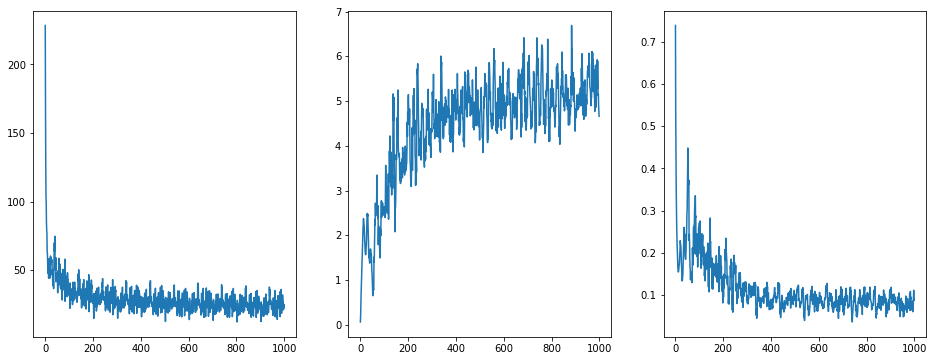

In [114]:
v = MNISTVAE()
BATCH_SIZE = 10
EPOCHS = 10
optimizer = optim.Adam(v.parameters(), lr=1e-03)
rloss, nloss, var = [], [], []
for epoch in tnrange(EPOCHS):
    for i in tnrange(0, len(my_train), BATCH_SIZE):
        batch_data, batch_label = zip(*my_train[i:i+BATCH_SIZE])
        batch_data = torch.cat(batch_data).view(-1, 1, 28, 28)
        reco_loss, norm_loss, total_loss = v.optimize(batch_data, optimizer)
        mu, log_sigma, z, rebuild = v(batch_data)
        rloss.append(reco_loss)
        nloss.append(norm_loss)
        var.append(torch.mean(log_sigma.exp()).detach().numpy().item())
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(rloss)
ax[1].plot(nloss)
ax[2].plot(var)
plt.show();

[0.1285857  0.11136462 0.123215   0.11115398]


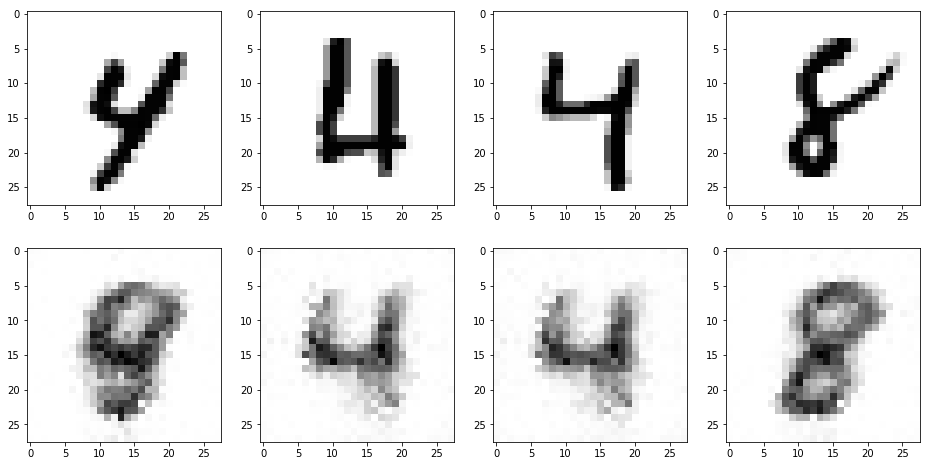

In [113]:
s = 0
test1_batch_data, _ = zip(*test1[s:s+4])
test1_batch_data = torch.cat(test1_batch_data).view(-1, 1, 28, 28)
mu, log_sigma, z, rebuild = v(test1_batch_data)
rebuild = np.transpose(rebuild.detach().numpy(), [0, 2, 3, 1])
print(torch.mean(log_sigma.exp(), dim=1).detach().numpy())
# Plot
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for i in range(4):
    ax[0, i].imshow(test1_batch_data[i,0,:,:], cmap="Greys")
    ax[1, i].imshow(rebuild[i,:,:,0], cmap="Greys")
plt.show();